In [2]:
from __future__ import division
import hoomd
import hoomd.md
import numpy
import ex_render
from matplotlib import pyplot
%matplotlib inline

In [ ]:
# Simulation context using hoomd.variant

#-------Initialize and define the unit cell

sim4 = hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [10.8, 0,   0],
                            a2 = [0,    1.2, 0],
                            a3 = [0,    0,   1.2],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['R'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);
system = hoomd.init.create_lattice(unitcell=uc, n=[2,18,18]);

#-----Add the particle type for the constituent particles.

system.particles.types.add('A');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies()

#-----Define the potential energy

nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')
lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

#-----Define pressure as a value that varies over time.

pressure = hoomd.variant.linear_interp(points = [(0, 1.0), (1e4, 10.0)], zero = 'now')


#-----Select an NPT integrator

hoomd.md.integrate.mode_standard(dt=0.005);
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.npt(group = rigid, kT = 1.0, tau = 0.5, tauP = 1.0, P = pressure);
hoomd.dump.gsd("trajectory4.gsd",
               period=2e3,
               group=hoomd.group.all(),
               overwrite=True);  

#-----Write output

log = hoomd.analyze.log(filename="log-output4.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure'],
                         period=100,
                         overwrite=True);

In [ ]:
data1 = numpy.genfromtxt(fname='log-output1_NPT_snapshot.log', skip_header=True);

In [ ]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data1[:,0], data1[:,10]);
pyplot.xlabel('time step');
pyplot.ylabel('pressure');

In [ ]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data1[:,0], data1[:,9]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');

In [ ]:
#ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory1_NPT_snapshot.gsd');

# Nematic Order Parameter

In [ ]:
import gsd
import gsd.hoomd

In [ ]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = numpy.empty(numpy.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        numpy.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, numpy.newaxis] * qj[..., 1:] +
                       qj[..., 0, numpy.newaxis] * qi[..., 1:] +
                       numpy.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = numpy.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [ ]:
t1 = gsd.hoomd.open('trajectory1_NPT_snapshot.gsd', 'rb')

In [ ]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, numpy.array([1, 0, 0]))

    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [ ]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, numpy.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( numpy.outer(arrowheads[i],arrowheads[i])  )
        
    Q = numpy.mean(results, axis=0)  # calculate mean without flattening array
    Q -= numpy.identity(3)/3.0       # subtract Identity/3
    
    return(Q)

In [ ]:
nematicOrderTensor(0,t1)

In [ ]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = numpy.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [ ]:
nematization(9,t1)

In [ ]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

In [ ]:
pyplot.figure(figsize=(4,2.2), dpi=140);

s1= sList(t1)

pyplot.scatter(
    numpy.arange(len(s1)), 
    s1);

pyplot.xlabel('sample');
pyplot.ylabel('S');
pyplot.ylim((0,1.1))

In [ ]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory1_NPT_snapshot.gsd');

In [10]:
sim2 = hoomd.context.initialize("");
uc = hoomd.lattice.fcc(a = 1.2)
snap = uc.get_snapshot()
snap.replicate(8,8,8)

#-----

system = hoomd.init.read_snapshot(snap)

#-----
particles = snap.particles.N

lx = snap.box.Lx
ly = snap.box.Ly
lz = snap.box.Lz
volume = lx * ly *lz

density = particles / volume
print(density)

notice(2): Group "all" created containing 2048 particles
2.314814814814815


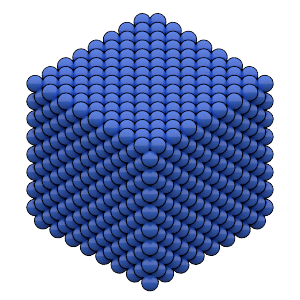

In [9]:
ex_render.render_sphere_frame(system.take_snapshot(all=True))

In [21]:
# Simulation of small molecules with big particles

sim2 = hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N = 2,
                            a1 = [10.0, 0,   0],
                            a2 = [0,    10., 0],
                            a3 = [0,    0,   10.0],
                            dimensions = 3,
                            position = [[2,2,2],[6.0,6.0,6.0]],
                            type_name = ['A','B'],
                            diameter = [1.0, 5.0],
                            mass = [1.0, 2.0]);
system = hoomd.init.create_lattice(unitcell = uc, n=[5,5,5]);

#-----Add the particle type for the constituent particles.

system.particles.types.add('C');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('A', 
                types=['C']*4,
                positions=[(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies()

notice(2): Group "all" created containing 250 particles
notice(2): constrain.rigid(): Creating 125 rigid bodies (adding 500 particles)


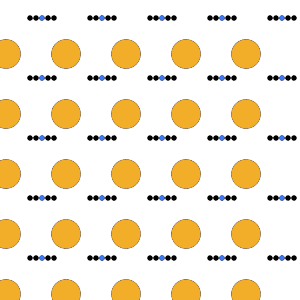

In [22]:
ex_render.render_disk_frame(system.take_snapshot(all=True))